In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during training to better suit your own data

For feature extraction transfer learning , you may train the top 1-3 layers of a pre-trained model with your own data. In fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model.

The four models covered in this notebook are:

* Model 0: A transfer learning model using the Keras Functional API
* Model 1: A feature extraction transfer model on 1% of the data with data augmentation
* Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
* Model 3: a fine-tuned transfer learning model on 10% of the data
* Model 4: a fine-tuned transfer learning model on 100% of the data

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Creating Helper Functions

A solution to having to recreate the same functions over and over again for each notebook is to create helper.py scripts and then import the necessary functionality when you need it.


In [ ]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-06-20 10:23:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-20 10:23:39 (22.7 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



The helper functions script has now been downloaded and can be used without us having to rewrite them



## Working with Less Data

Let's see how we can use the pretrained models within the tf.keras.applications module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, `image_dataset_from_directory()` which is part of the `tf.keras.preprocessing module.`

inally, we'll also be practicing using the Keras Functional API for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.


In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-06-20 10:23:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 64.233.191.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   210MB/s    in 0.8s    

2022-06-20 10:23:45 (210 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the ImageDataGenerator class. And while this works well and is still very commonly used, this time we're going to use the image_data_from_directory function.

It works much the same way as ImageDataGenerator's flow_from_directory method meaning your images need to be in the usual classified format.

One of the main benefits of using tf.keras.prepreprocessing.image_dataset_from_directory() rather than ImageDataGenerator is that it creates a tf.data.Dataset object rather than a generator. The main advantage of this is the tf.data.Dataset API is much more efficient (faster) than the ImageDataGenerator API which is paramount for larger datasets.



In [ ]:
# Creating data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) 

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check the training data datatype
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:

* `(None, 224, 224, 3)` refers to the tensor shape of our images where None is the batch size, 224 is the height (and width) and 3 is the color channels (red, green, blue).
* `(None, 10)` refers to the tensor shape of the labels where None is the batch size and 10 is the number of possible labels (the 10 different food classes).
* Both image tensors and labels are of the datatype `tf.float32`.

nother benefit of using the `tf.data.Dataset` API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building a Transfer Learning Model Using the Keras Functional API

In [ ]:
#1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

#3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224,224,3), name ="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
#Check data shape after passing it to the base model
print(f"Shape after base_model: {x.shape}")

#6. Average pool all the outputs of the base model (aggregate all the inportant information, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D (name = "global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

#8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

#9. Compile the model
model_0.compile(loss = 'categorical_crossentropy',
                optimizer  =tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

#10. Fit the model (we use less steps for valdation so its faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data_10_percent,
                                 validation_steps = int(0.25*len(test_data_10_percent)),
                                 callbacks = [create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220620-102351
Epoch 1/5
24/24 [==============================] - 93s 4s/step - loss: 1.8763 - accuracy: 0.4173 - val_loss: 1.3184 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 80s 3s/step - loss: 1.1339 - accuracy: 0.7427 - val_loss: 0.9250 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 85s 4s/step - loss: 0.8364 - accuracy: 0.8080 - val_loss: 0.7243 - val_accuracy: 0.8503
Epoch 4/5
24/24 [==============================] - 81s 3s/step - loss: 0.6862 - accuracy: 0.8440 - val_loss: 0.6567 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 81s 3s/step - loss: 0.5815 - accuracy: 0.8627 - val_loss: 0.5765 - val_accuracy: 0.8734


Nice! After a minute or so of training our model performs incredibly well on both the training (85%+ accuracy) and test sets (~87% accuracy).

This is incredible. All thanks to the power of transfer learning.

It's important to note the kind of transfer learning we used here is called feature extraction transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (EfficientNetB0), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. For now, the benefits of this main not seem clear but when you start to build more sophisticated models, you'll probably want to use the Functional API. So it's important to have exposure to this way of building models.

In [ ]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:

base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Our overall model has five layers but really, one of those layers (efficientnetb0) has 236 layers.

You can see how the output shape started out as (None, 224, 224, 3) for the input layer (the shape of our images) but was transformed to be (None, 10) by the output layer (the shape of our labels), where None is the placeholder for the batch size.

Notice too, the only trainable parameters in the model are those in the output layer.

How do our model's training curves look?

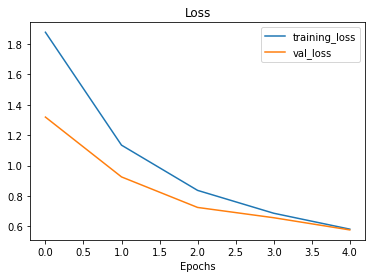

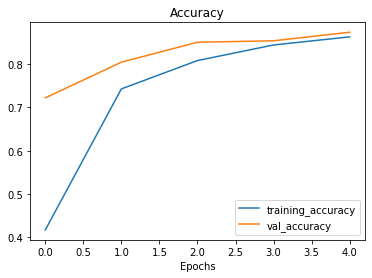

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

Lets try to unpack how the tf.keras.layers.GlobalAveragePooling2D() layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.



In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


You can see the tf.keras.layers.GlobalAveragePooling2D() layer condensed the input tensor from You can see the tf.keras.layers.GlobalAveragePooling2D() layer condensed the input tensor from shape (1, 4, 4, 3) to (1, 3). It did so by averaging the input_tensor across the middle two axes.

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (tf.keras.layers.Dense()), it also condenses the information found by the base model into a lower dimension **feature vector.**

##Running a series of transfer learning experiments

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [ ]:
 #Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2022-06-20 10:32:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.2’

10_food_classes_1_p 100%[===================>] 127.42M   120MB/s    in 1.1s    

2022-06-20 10:32:52 (120 MB/s) - ‘10_food_classes_1_percent.zip.2’ saved [133612354/133612354]



In [ ]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

Looks like we only got **7** images of each class, should be a bit of a challenge for our model

In [ ]:
import tensorflow as tf 
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           batch_size = 32,
                                                                           image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size = IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


##Adding Data Augmentation Right Into the Model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the `tf.keras.layers.experimental.preprocessing` module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
>* Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
*Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.


In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.7.0

Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220527125636.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 665.5 MB 70.2 MB/s
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
     |████████████████████████████████| 463 kB 40.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0


In [ ]:
import tensorflow as tf
tf.__version__
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
 # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name = "data_augmentation")

And that's it! Our data augmentation Sequential model is ready to go. As you'll see shortly, we'll be able to slot this "model" as a layer into our transfer learning model later on.

But before we do that, let's test it out by passing random images through it.

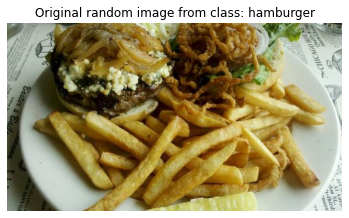

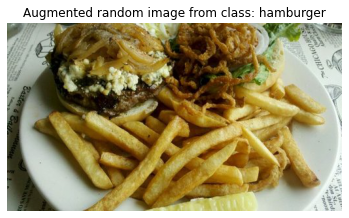

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) #choose a random class
target_dir = "10_food_classes_1_percent/train/" +target_class #create teh target directory
random_image = random.choice(os.listdir(target_dir)) #choose random imagefrom target directory
random_image_path = target_dir +"/" + random_image #create chose random image path
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); 

#Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) #data augmentation requires shape (None,height,width,3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) #requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


Let's build a model with the Functional API. We'll run through all of the same steps as before except for one difference, we'll add our data augmentation Sequential model as a layer immediately after the input layer

##Model 1: Feature Extraction Transfer Learning on 1% of the Data with Data Augmentation

In [ ]:
#setup the input and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

#Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

#Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

#Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#Put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

#Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

#compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

#Fit the model 
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25*len(test_data)),
                                callbacks = [create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])



Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220620-104915
Epoch 1/5
3/3 [==============================] - 111s 45s/step - loss: 2.4559 - accuracy: 0.0571 - val_loss: 2.2311 - val_accuracy: 0.1645
Epoch 2/5
3/3 [==============================] - 45s 22s/step - loss: 2.1883 - accuracy: 0.2571 - val_loss: 2.0906 - val_accuracy: 0.2845
Epoch 3/5
3/3 [==============================] - 45s 21s/step - loss: 1.9885 - accuracy: 0.3571 - val_loss: 2.0060 - val_accuracy: 0.3569
Epoch 4/5
3/3 [==============================] - 46s 22s/step - loss: 1.8352 - accuracy: 0.4857 - val_loss: 1.9100 - val_accuracy: 0.4079
Epoch 5/5
3/3 [==============================] - 45s 21s/step - loss: 1.6356 - accuracy: 0.6429 - val_loss: 1.8172 - val_accuracy: 0.4523


Wow! We've achieved 46% on the validation set using just 7 images per class!

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

There it is. We've now got data augmentation built right into the our model. This means if we saved it and reloaded it somewhere else, the data augmentation layers would come with it.

The important thing to remember is **data augmentation only runs during training**. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

To see this in action, let's evaluate our model on the test data.

In [ ]:
#Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 187s 2s/step - loss: 1.8165 - accuracy: 0.4744


[1.816548466682434, 0.47440001368522644]

The results here may be slightly better or worse than the log outputs of our mpdel because during training we only evaluate our model on 25% of the test data.

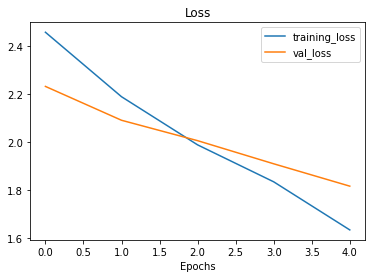

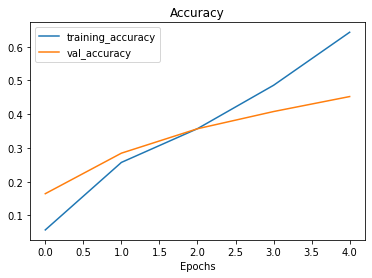

In [ ]:
plot_loss_curves(history_1_percent)

##Model 2: Feature Extraction Transfer Learning with 10% of Data and Data Augmentation

In [ ]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Creating a ModelCheckpoint Callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The `ModelCheckpoint` callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

In [ ]:
#Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

>🤔 Question: What's the difference between saving the entire model (SavedModel format) and saving the weights only?

The `SavedModel` format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable initial_epochs and set it to 5 to use later.

We'll also add in our `checkpoint_callback` in our list of callbacks.

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220620-105933
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9991 - accuracy: 0.3373
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 161s 6s/step - loss: 1.9991 - accuracy: 0.3373 - val_loss: 1.4912 - val_accuracy: 0.6562
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3740 - accuracy: 0.6813
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 95s 4s/step - loss: 1.3740 - accuracy: 0.6813 - val_loss: 1.0362 - val_accuracy: 0.7615
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0707 - accuracy: 0.7280
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 94s 4s/step - loss: 1.0707 - accuracy: 0.7280 - val_loss: 0.8352 - val_accuracy: 0.8125
Epoch 4/5

In [ ]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 159s 2s/step - loss: 0.6953 - accuracy: 0.8060


[0.6953396201133728, 0.8059999942779541]

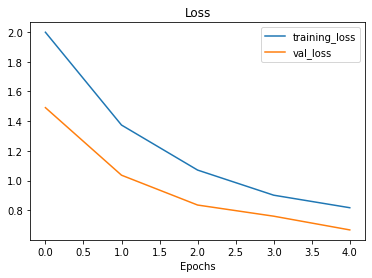

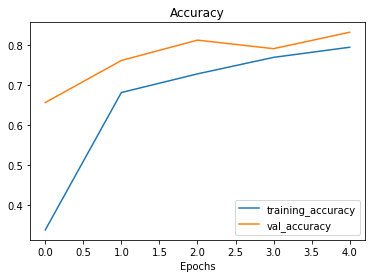

In [ ]:

# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

Looking at these, our model's performance with 10% of the data and data augmentation isn't as good as the model with 10% of the data without data augmentation (see model_0 results above), however the curves are trending in the right direction, meaning if we decided to train for longer, its metrics would likely improve.

Since we checkpointed (is that a word?) our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

To load saved model weights you can use the the `load_weights()` method, passing it the path where your saved weights are stored.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 164s 2s/step - loss: 0.6953 - accuracy: 0.8060


In [ ]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

##Model:3 Fine-Tuning an Existing Model on 10% of the Data

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

>🔑 **Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data. 

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


Looking good. We've got an input layer, a Sequential layer (the data augmentation model), a Functional layer (EfficientNetB0), a pooling layer and a Dense layer (the output layer).

How about a summary?

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

Alright, it looks like all of the layers in the efficientnetb0 layer are frozen. We can confirm this using the trainable_variables attribute.

In [ ]:
# How many layers are trainable in our base model?
print(len(model_2.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)

0


In [ ]:
print(len(base_model.trainable_variables))

0


Beautiful. This is exactly what we're after.

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

>🤔 **Question:** How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

ery time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

In [ ]:
print(len(model_2.trainable_variables))

12


Wonderful, it looks like our model has a total of 10 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

Time to fine-tune!

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the `initial_epoch` parameter of the `fit()` method. We'll pass it the last epoch of the previous model's training history (`history_10_percent_data_aug.epoch[-1]`).

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220620-111654
Epoch 5/10
24/24 [==============================] - 149s 6s/step - loss: 0.6995 - accuracy: 0.8013 - val_loss: 0.5635 - val_accuracy: 0.8207
Epoch 6/10
24/24 [==============================] - 98s 4s/step - loss: 0.5676 - accuracy: 0.8227 - val_loss: 0.5257 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - 97s 4s/step - loss: 0.5051 - accuracy: 0.8400 - val_loss: 0.5049 - val_accuracy: 0.8355
Epoch 8/10
24/24 [==============================] - 98s 4s/step - loss: 0.4397 - accuracy: 0.8760 - val_loss: 0.4754 - val_accuracy: 0.8405
Epoch 9/10
24/24 [==============================] - 91s 4s/step - loss: 0.4012 - accuracy: 0.8827 - val_loss: 0.4818 - val_accuracy: 0.8372
Epoch 10/10
24/24 [==============================] - 94s 4s/step - loss: 0.3823 - accuracy: 0.8720 - val_loss: 0.4692 - val_accuracy: 0.8339


In [ ]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 155s 2s/step - loss: 0.4958 - accuracy: 0.8260


Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare the before and after?

In [ ]:

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3373333215713501, 0.6813333630561829, 0.7279999852180481, 0.7693333625793457, 0.7946666479110718, 0.8013333082199097, 0.8226666450500488, 0.8399999737739563, 0.8759999871253967, 0.8826666474342346, 0.871999979019165]


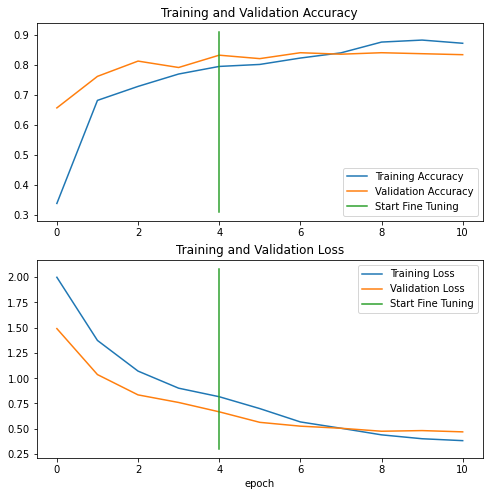

In [ ]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

Alright, alright, seems like the curves are heading in the right direction after fine-tuning. But remember, it should be noted that fine-tuning usually works best with larger amounts of data.

##Model 4: Fine-Tuning an Existing Model Over All of the data

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2022-06-20 11:31:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 64.233.191.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   183MB/s    in 2.7s    

2022-06-20 11:31:39 (183 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

In [ ]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) # revert model back to saved weights

In [ ]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 164s 2s/step - loss: 0.6953 - accuracy: 0.8060


[0.6953396201133728, 0.8059999942779541]

In [ ]:
# Check to see if the above two results are the same (they should be)
results_10_percent_data_aug

[0.6953396201133728, 0.8059999942779541]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Recompile after unfreezing layers
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220620-123627
Epoch 5/10
235/235 [==============================] - 591s 3s/step - loss: 0.4009 - accuracy: 0.8735 - val_loss: 0.4201 - val_accuracy: 0.8602
Epoch 6/10
235/235 [==============================] - 565s 2s/step - loss: 0.3724 - accuracy: 0.8800 - val_loss: 0.3845 - val_accuracy: 0.8766
Epoch 7/10
235/235 [==============================] - 561s 2s/step - loss: 0.3479 - accuracy: 0.8912 - val_loss: 0.3748 - val_accuracy: 0.8783
Epoch 8/10
235/235 [==============================] - 590s 3s/step - loss: 0.3351 - accuracy: 0.8925 - val_loss: 0.3338 - val_accuracy: 0.8964
Epoch 9/10
235/235 [==============================] - 574s 2s/step - loss: 0.3145 - accuracy: 0.9008 - val_loss: 0.3378 - val_accuracy: 0.8882
Epoch 10/10
235/235 [==============================] - 570s 2s/step - loss: 0.3003 - accuracy: 0.9068 - val_loss: 0.3744 - val_accuracy: 0.8701


Lets evaluate

In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

Nice! It looks like fine-tuning with all of the data has given our model a boost, how do the training curves look?

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

Thanks to the TensorBoard callback we made with our helper function create_tensorflow_callback(), we've been tracking our modelling experiments the whole time.

How about we upload them to TensorBoard.dev and check them out?

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished